# Censored regression in PyMC3 [WORK IN PROGRESS]
**Author:** [Ben Vincent](https://github.com/drbenvincent)

This notebook provides an example of how to do linear regression in the case where you have censored observations. Truncation and censoring are both missing data problems:
- **censored data:** data outside the range of some measurement limits are set at those floor and ceiling values
- **truncated data:** data outside the range of some measurement limits are simply absent.

In this notebook we consider interval censoring, where we have both upper and lower censoring bounds.

We simulate some true data, then apply censoring bounds. We fit a standard linear regression model to both the raw and the censored datasets to see that our estimates may be biased. Then we look at a censored regression model.

Optional: If you want to use autoformatter, then 

    pip install nb-black

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

import pymc3 as pm
import arviz as az
from scipy.stats import norm

print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on arviz v{az.__version__}")

Running on PyMC3 v3.8
Running on arviz v0.7.0


## Define options

In [3]:
SEED = 123

n_samples = 1_000
m = 1
c = 0
N = 100

censor_bounds = [-1.5, 1.5]

sample_options = {
    "tune": 1_000,
    "draws": n_samples,
    "chains": 2,
    "cores": 2,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

np.random.seed(SEED)

## Create synthetic dataset

In [4]:
def make_data():
    x = np.random.randn(N)
    ϵ = np.random.randn(N) * 0.5
    y = m * x + c + ϵ
    return (x, y)


x, y = make_data()

In [5]:
def censor_y(x, y, censor_bounds):
    # set up data
    xc = x
    yc = y.copy()
    # indicator variables (boolean) of what is censored
    censor_low = yc < censor_bounds[0]
    censor_high = yc > censor_bounds[1]
    censored = (censor_low) | (censor_high)
    # do the censoring
    yc[censor_low] = censor_bounds[0]
    yc[censor_high] = censor_bounds[1]
    return xc, yc, censor_low, censor_high, censored


xc, yc, censor_low, censor_high, censored = censor_y(x, y, censor_bounds)
n_censor_low = sum(censor_low)
n_censor_high = sum(censor_high)

In [6]:
def plot_true(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    x = np.array([-3, 3])
    ax.plot(x, m * x + c, "r", lw=3, label="True")
    ax.legend()

[Text(0, 0.5, 'y'), Text(0.5, 0, 'x'), Text(0.5, 1.0, 'Censored data')]

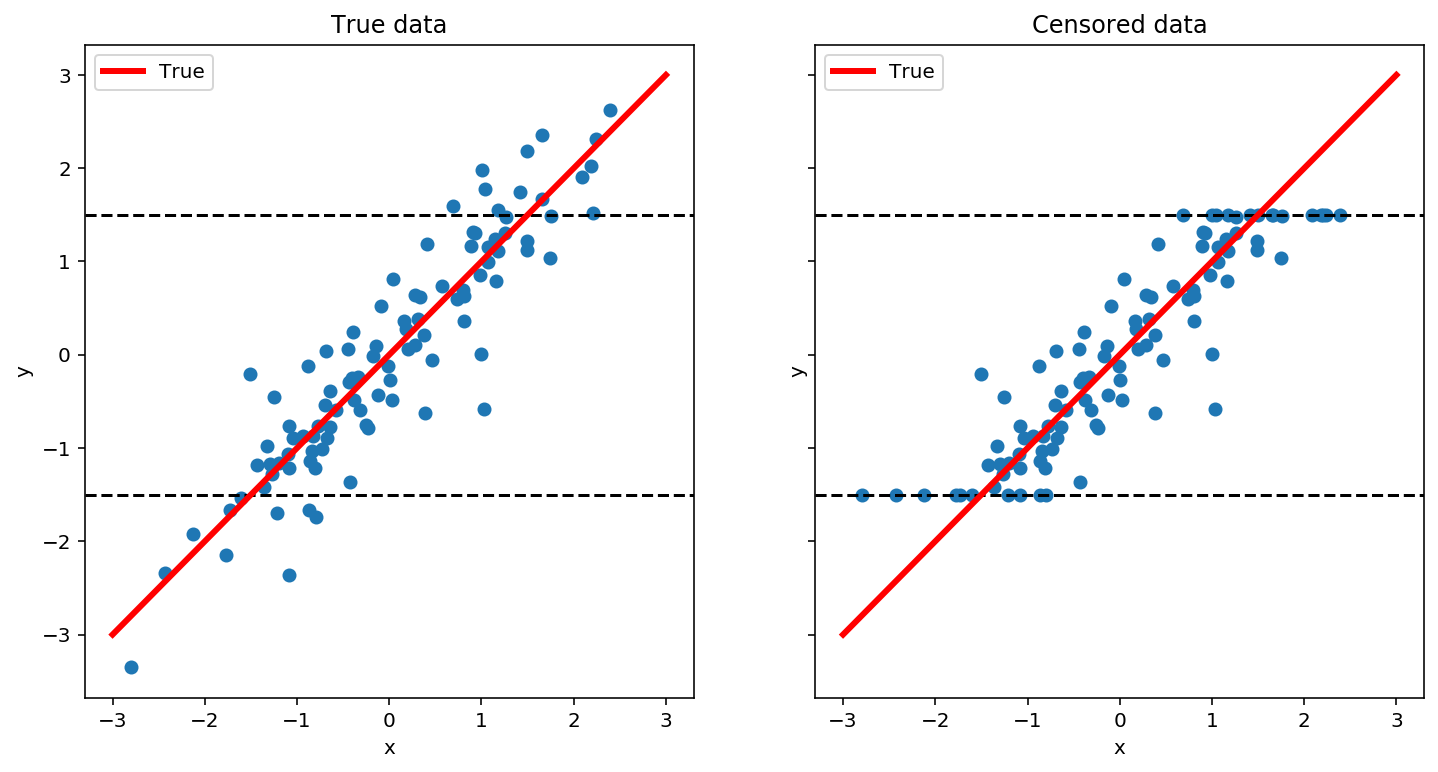

In [7]:
def plot_data(x, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    ax.scatter(x, y)
    for bound in censor_bounds:
        ax.axhline(y=bound, c="k", ls="--")
    ax.set(xlabel="x", ylabel="y")
    return ax


fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

_ = plot_data(x, y, ax=ax[0])
plot_true(ax=ax[0])
ax[0].set(title="True data", xlabel="x", ylabel="y")

_ = plot_data(xc, yc, ax=ax[1])
plot_true(ax=ax[1])
ax[1].set(title="Censored data", xlabel="x", ylabel="y")

Visualise the process in more detail...

In [8]:
# fig, ax = plt.subplots(figsize=(12, 12))

# # plot data
# ax1 = plt.subplot(2, 1, 1)
# _ = plot_data(xc, yc, ax=ax1)
# # plot cross sections
# x_sections = [-2, 0, 2]
# for _x in x_sections:
#     ax1.axvline(x=_x, c="r")

# ax1.plot([-3, 3], [-3, 3], "k", label="true regression line")
# ax1.set(title="Censored data", xlim=(-3, 3), ylim=(-3, 3))
# ax1.legend()


# def plot_cross_section(ax, x, μ):
#     ax.set(ylim=(-3, 3))
#     ax.set_title(f"x={x}", color="r")
#     # plot bounds
#     for bound in censor_bounds:
#         ax.axhline(y=bound, c="k", ls="--")
#     # plot normal distribution
#     y = np.linspace(-3, 3, 500)
#     x = norm.pdf(y, loc=μ, scale=0.5)
#     ax.plot(x, y)
#     ax.fill_betweenx(
#         y, 0, x, where=(y > censor_bounds[0]) & (y < censor_bounds[1]), alpha=0.2
#     )
#     # plot line to mu
#     ax.plot([0, np.max(x)], [μ, μ], "k")


# ax2 = plt.subplot(2, 3, 4)
# plot_cross_section(ax2, x=-2, μ=-2)

# ax3 = plt.subplot(2, 3, 5)
# plot_cross_section(ax3, x=0, μ=0)

# ax4 = plt.subplot(2, 3, 6)
# plot_cross_section(ax4, x=2, μ=2)

## Regular regression applied to raw and censored data

In [9]:
def regression(x, y):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=m * x + c, sd=σ, observed=y)

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [10]:
model, trace = regression(x, y)
_, trace_t = regression(xc, yc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]


If you want, you can visualise the traces with:

    pm.traceplot(trace, var_names=["m", "c", "σ"])
    pm.traceplot(trace_t, var_names=["m", "c", "σ"])

Visualise...

In [11]:
def plot_posterior_predictive(trace, ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    # plot posterior predictive
    x_ppc = np.array([-3, +3])

    for n in range(n_samples):
        y_ppc = x_ppc * trace["m"][n] + trace["c"][n]
        ax.plot(x_ppc, y_ppc, "k", alpha=0.01, rasterized=True)

    return ax

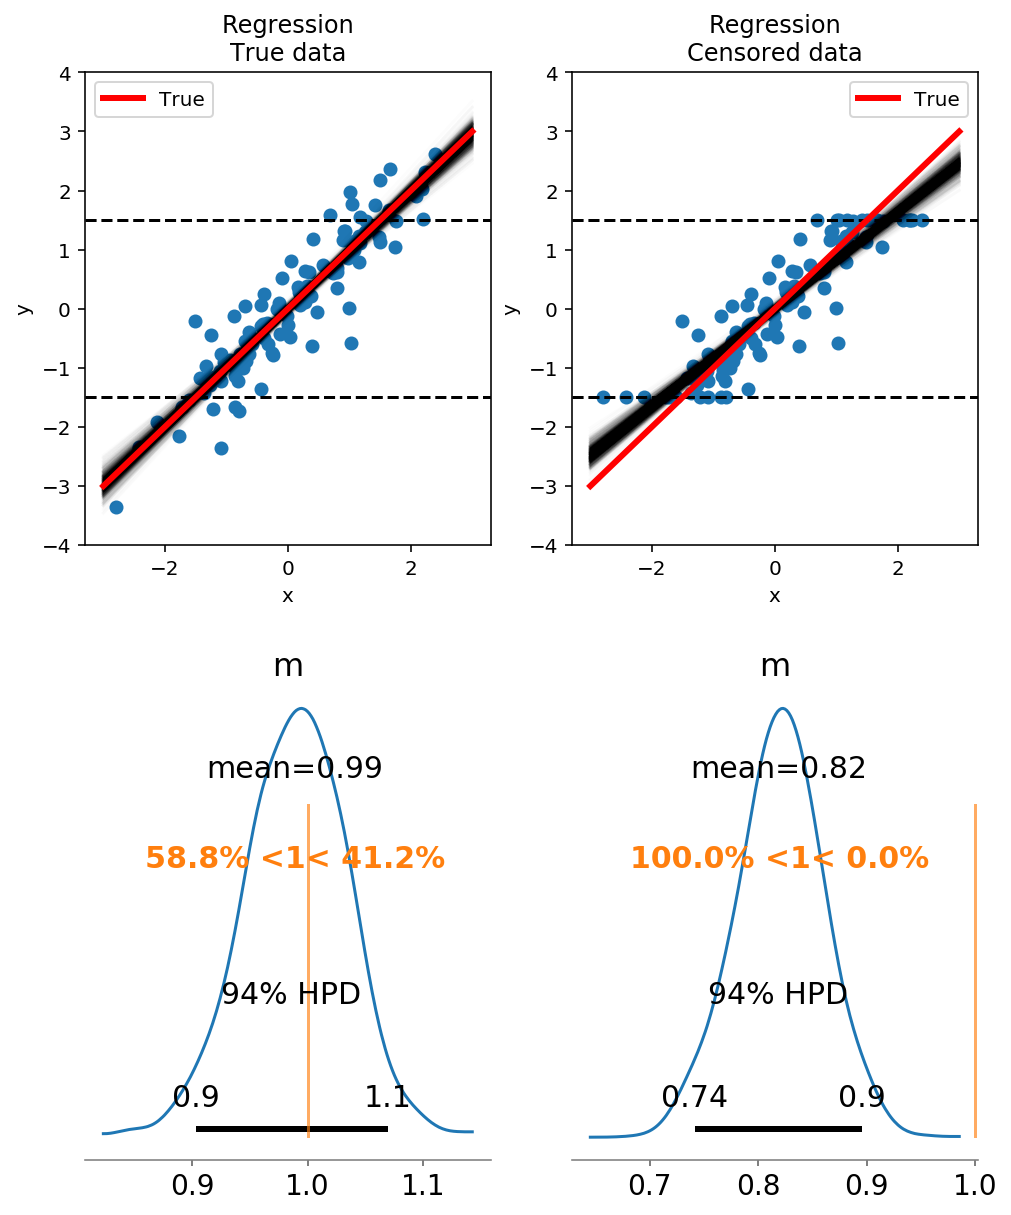

In [12]:
xfig, ax = plt.subplots(2, 2, figsize=(8, 10))

data_ylim = [-4, 4]

# True data =================================================
# data space
_ = plot_data(x, y, ax=ax[0, 0])
_ = plot_posterior_predictive(trace, ax=ax[0, 0])
ax[0, 0].set(title="Regression\nTrue data", xlabel="x", ylabel="y", ylim=data_ylim)
plot_true(ax=ax[0, 0])
# parameter space
az.plot_posterior(trace, var_names=["m"], ax=ax[1, 0], ref_val=m)

# Truncated data ============================================
_ = plot_data(xc, yc, ax=ax[0, 1])
ax[0, 1].set(title="Regression\nCensored data", xlabel="x", ylabel="y", ylim=data_ylim)
_ = plot_posterior_predictive(trace_t, ax=ax[0, 1])
plot_true(ax=ax[0, 1])
# parameter space
az.plot_posterior(trace_t, var_names=["m"], ax=ax[1, 1], ref_val=m)


# spacing between rows
plt.subplots_adjust(hspace=0.3)

We can see that regression on censored data produces bias in out estimate of the slope.

## Censored regression (aka Tobit regression)

In [13]:
def censored_regression(x, y):
    """Sample from a censored linear regression model (aka Tobit Regression)"""

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)

        y_likelihood = pm.TruncatedNormal(
            "y_likelihood",
            mu=m * x + c,
            sd=σ,
            observed=y,
            lower=censor_bounds[0],
            upper=censor_bounds[1],
        )

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [14]:
_, trace_censored = censored_regression(xc, yc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]


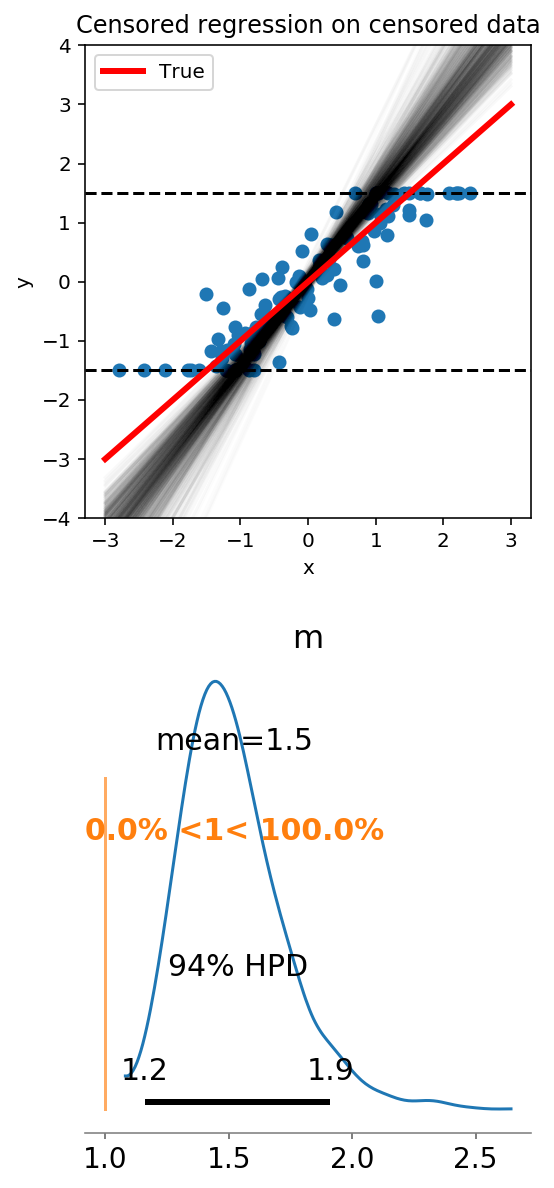

In [22]:
xfig, ax = plt.subplots(2, 1, figsize=(4, 10))

data_ylim = [-4, 4]

# True data =================================================
# data space
_ = plot_data(xc, yc, ax=ax[0])
_ = plot_posterior_predictive(trace_censored, ax=ax[0])
ax[0].set(
    title="Censored regression on censored data",
    xlabel="x",
    ylabel="y",
    ylim=data_ylim,
)
plot_true(ax=ax[0])
# parameter space
az.plot_posterior(trace_censored, var_names=["m"], ax=ax[1], ref_val=m)

# spacing between rows
plt.subplots_adjust(hspace=0.3)

This SHOULD work, but it does not. This might be because the observed data is already censored and there could be numerical precision issues such that the likelihood is treating the censored data as uncensored.

## TEST: setting data outside bounds as 'missing'

In [16]:
def missing_y(x, y, censor_bounds):
    # set up data
    xm = x
    ym = y.copy()
    # indicator variables (boolean) of what is censored
    missing_low = ym < censor_bounds[0]
    missing_high = ym > censor_bounds[1]
    missing = (missing_low) | (missing_high)
    # set dat aoutside bounds as missing
    ym[missing_low] = np.nan
    ym[censor_high] = np.nan
    return xm, ym, missing_low, missing_high, missing


# set data outside bounds as missing
xm, ym, missing_low, missing_high, missing = missing_y(x, y, censor_bounds)

In [17]:
data = pd.DataFrame({"x": xm, "y": ym})

In [18]:
def regression_missing(data):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal(
            "y_likelihood", mu=m * data.x + c, sd=σ, observed=data.y
        )

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [19]:
# regular regression but with y outside of bounds are set as missing
model, trace_missing = regression_missing(data)

/Users/benjamv/opt/anaconda3/lib/python3.7/site-packages/pymc3/model.py:1506: ImputationWarning: Data in y_likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_likelihood_missing, σ, c, m]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe68199dc90>,
      dtype=object)

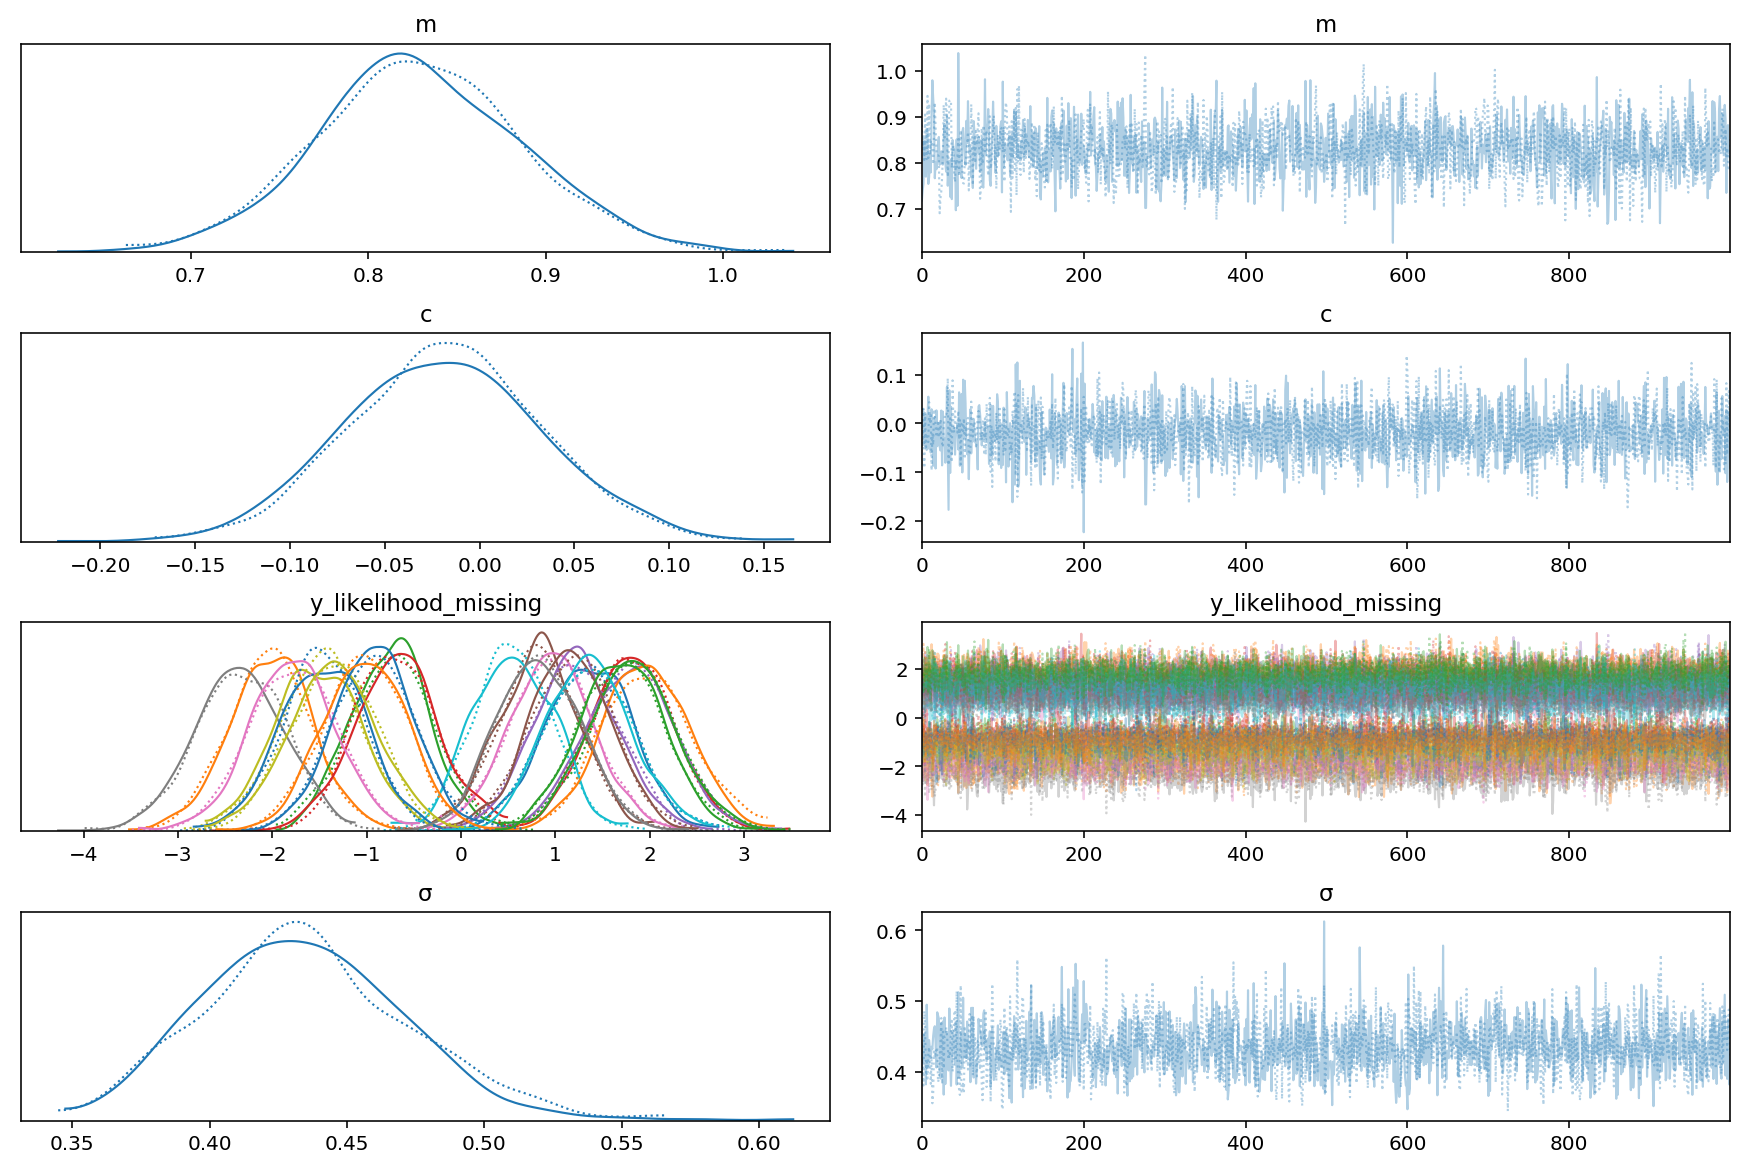

In [20]:
pm.traceplot(trace_missing)

You can see that the mising y values are being imputed. Although here I am not making an attempt to visualise these imputed values against the known true values.

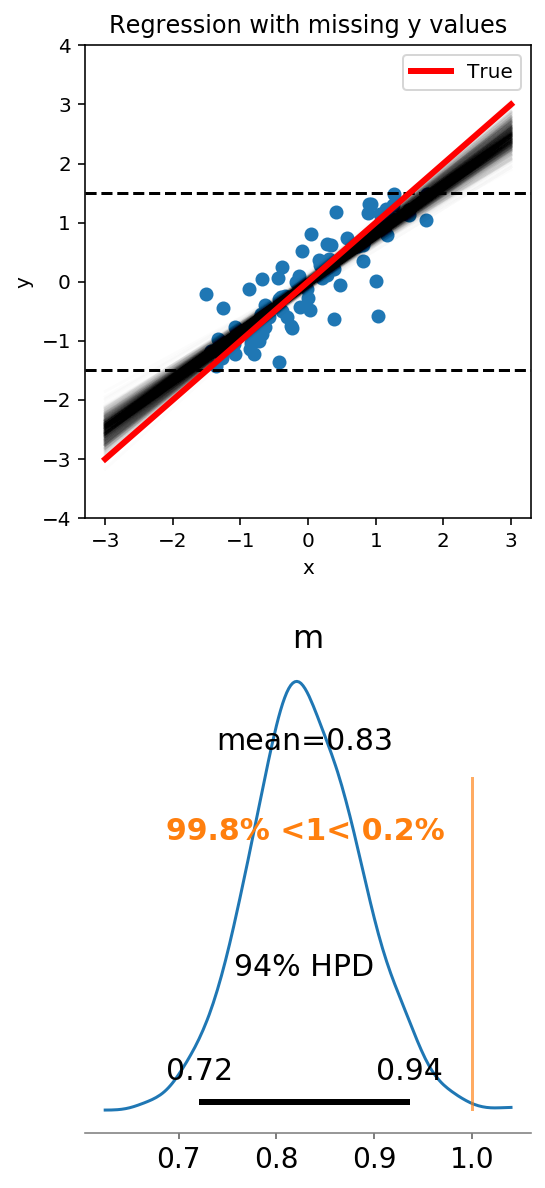

In [21]:
xfig, ax = plt.subplots(2, 1, figsize=(4, 10))

data_ylim = [-4, 4]

# True data =================================================
# data space
_ = plot_data(xm, ym, ax=ax[0])
_ = plot_posterior_predictive(trace_missing, ax=ax[0])
ax[0].set(
    title="Regression with missing y values", xlabel="x", ylabel="y", ylim=data_ylim,
)
plot_true(ax=ax[0])
# parameter space
az.plot_posterior(trace_missing, var_names=["m"], ax=ax[1], ref_val=m)

# spacing between rows
plt.subplots_adjust(hspace=0.3)

This does not work, in that it does not remove the bias in the slope parameter.